
# Getting started

Once you've chosen your scenario, download the data from the Iowa website in csv format. Start by loading the data with pandas. You may need to parse the date columns appropriately.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns

from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error

import random

%matplotlib inline

In [ ]:
path = '/Users/mjschillawski/Google Drive/Data/generalassembly/data/'
filename = 'Iowa_Liquor_sales_sample_10pct.csv'

## Load the data into a DataFrame
data = pd.read_csv(path+filename)

## Transform the dates if needed, e.g.
data["Date"] = pd.to_datetime(data["Date"])

In [4]:
def DataInspect(dataframe):
    '''Original function (previously called eda) created by Ritika Bhasker
       Good first step when starting any project. Provides overview of
       dataset including missing values, duplicates and types.
       Takes a Pandas dataframe as the argument.'''
    print("Dataframe Shape:", dataframe.shape,"\n")
    print("Duplicate Rows:", dataframe.duplicated().sum(),"\n") #Added this
    print("Dataframe Types \n\n", dataframe.dtypes,"\n")    
    print("Missing Values \n\n", dataframe.isnull().sum(),"\n")
    print("Dataframe Describe \n\n", dataframe.describe(include='all'),"\n")


    print('Unique Values by Variable')
    for item in dataframe:
        print(item,':',dataframe[item].nunique())

In [7]:
DataInspect(data)

Dataframe Shape: (270920, 18) 

Duplicate Rows: 0 

Dataframe Types 

 Date                     datetime64[ns]
Store Number                      int64
City                             object
Zip Code                         object
County Number                   float64
County                           object
Category                        float64
Category Name                    object
Vendor Number                     int64
Item Number                       int64
Item Description                 object
Bottle Volume (ml)                int64
State Bottle Cost                object
State Bottle Retail              object
Bottles Sold                      int64
Sale (Dollars)                   object
Volume Sold (Liters)            float64
Volume Sold (Gallons)           float64
dtype: object 

Missing Values 

 Date                        0
Store Number                0
City                        0
Zip Code                    0
County Number            1077
County                   

In [8]:
#Drop duplicate rows

def dropduplicates(df):
    print('Original shape:',df.shape)
    temp =  df.drop(df[df.duplicated()].index,axis=0)
    print('Dropped duplicates, new shape: ',temp.shape)
    return temp

data = dropduplicates(data)

Original shape: (270920, 18)
Dropped duplicates, new shape:  (270920, 18)


In [9]:
data.rename(columns={'Date':'date', 'Store Number':'storenum', 'City':'city', 
                     'Zip Code':'zipcode', 'County Number':'countynum', 
                     'County':'county',
                     'Category':'category', 'Category Name':'categoryname', 
                     'Vendor Number':'vendornum',
                     'Item Number':'itemnum','Item Description':'itemdescription', 
                     'Bottle Volume (ml)':'bottlevol_ml', 
                     'State Bottle Cost':'statebottlecost',
                     'State Bottle Retail':'statebottleretail', 
                     'Bottles Sold':'bottlessold', 
                     'Sale (Dollars)':'sale_dollars',
                     'Volume Sold (Liters)':'volsold_liters', 
                     'Volume Sold (Gallons)':'volsold_gallons'},inplace=True)

In [10]:
#Extract unique City/Zipcode/CountyNum/County tuples from list
#Drop if CountyNum and County are null
#https://chrisalbon.com/python/data_wrangling/pandas_dropping_column_and_rows/

counties = data[data[['city','zipcode','countynum',
                      'county']].duplicated()==False][['city','zipcode',
                                                       'countynum','county']]
counties = counties[counties['countynum'].notnull() & counties['county'].notnull()]
counties['county'].nunique()

99

In [11]:
#Check for duplicated City/Zipcode tuples assigned to multiple counties.
counties[counties.duplicated(['city','zipcode'],False)].sort_values('city')

,city,zipcode,countynum,county
1415,ACKLEY,50601,42.0,Hardin
7574,ACKLEY,50601,94.0,Webster
300,BETTENDORF,52722,82.0,Scott
337,BETTENDORF,52722,48.0,Iowa
192,CLIVE,50325,77.0,Polk
1292,CLIVE,50325,25.0,Dallas
488,FORT DODGE,50501,42.0,Hardin
33,FORT DODGE,50501,94.0,Webster
3771,NORTH LIBERTY,52317,48.0,Iowa
253,NORTH LIBERTY,52317,52.0,Johnson


In [12]:
#Identify list of observations missing Category & CategoryName
#Find matching city/zip pair from COUNTIES list
#If unique observation: replace
#If multiple occurences: hotdeck, randomly choosing value to substitute

random.seed(19871006)
missing = data[np.logical_and(data['countynum'].isnull(), data['county'].isnull())]

start = len(missing)
print('Missing values:',start)

for i,row in missing.iterrows():
    index = i
    city_missing = row[2]
    zipcode_missing = row[3]
    
    replacement = counties[(counties['city']==city_missing) & 
                           (counties['zipcode']==zipcode_missing)]
    if len(replacement) == 1:
        new_countynum = replacement.iat[0,2]
        new_county = replacement.iat[0,3]
    
    elif len(replacement) > 1:
        srs = replacement.sample(1,axis=0)
        new_countynum = srs.iat[0,2]
        new_county = srs.iat[0,3]
    
    data.iat[index,4] = new_countynum
    data.iat[index,5] = new_county

end = len(data[np.logical_and(data['countynum'].isnull(), data['county'].isnull())])
print('Remaining null values:',end)

Missing values: 1077
Remaining null values: 902


In [14]:
products = data[data[['category','categoryname','itemnum',
                      'itemdescription']].duplicated()==False][
    ['category','categoryname','itemnum','itemdescription']]

products = products[products['categoryname'].notnull() & 
                    products['category'].notnull()]

products[products.duplicated(['itemnum',
                              'itemdescription'],False)].sort_values('itemdescription')

,category,categoryname,itemnum,itemdescription
111621,1012210.0,SINGLE MALT SCOTCH,903550,Aberlour 16yr Scotch
125172,1012300.0,IRISH WHISKIES,903550,Aberlour 16yr Scotch
13225,1012210.0,SINGLE MALT SCOTCH,4096,Ardbeg 10 Yr Islay Single Malt Scotch
26951,1012300.0,IRISH WHISKIES,4096,Ardbeg 10 Yr Islay Single Malt Scotch
248338,1012300.0,IRISH WHISKIES,4090,Ardbeg Corryvreckan
2336,1012210.0,SINGLE MALT SCOTCH,4090,Ardbeg Corryvreckan
11236,1012300.0,IRISH WHISKIES,4111,Ardbeg Uigeadail
883,1012210.0,SINGLE MALT SCOTCH,4111,Ardbeg Uigeadail
255111,1101100.0,AMERICAN ALCOHOL,27246,Artisan Grain Original Moonshine
43786,1081700.0,DISTILLED SPIRITS SPECIALTY,27246,Artisan Grain Original Moonshine


In [15]:
#Look up category and category name for missing values
#Hot deck if necessary

missing = data[np.logical_and(data['category'].isnull(), data['categoryname'].isnull())]

start = len(missing)
print('Missing values:',start)

for i,row in missing.iterrows():
    index = i
    itemnum_missing = row[9]
    itemdescription_missing = row[10]
    
    replacement = products[(products['itemnum']==itemnum_missing) & 
                          (products['itemdescription']==itemdescription_missing)]
    
    if len(replacement) == 1:
        new_category = replacement.iat[0,0]
        new_categoryname = replacement.iat[0,1]
    
    elif len(replacement) > 1:
        srs = replacement.sample(1,axis=0)
        new_category = srs.iat[0,0]
        new_categoryname = srs.iat[0,1]
    
    elif len(replacement) < 1:
        pass
    
    
    if len(replacement) >= 1:
        data.iat[index,6] = new_category
        data.iat[index,7] = new_categoryname

end = len(data[np.logical_and(data['category'].isnull(), data['categoryname'].isnull())])
print('Remaining null values:',end)

Missing values: 68
Remaining null values: 67


In [16]:
#Remove dollar signs and convert to numeric

bad_col = ['statebottlecost','statebottleretail','sale_dollars']

for item in bad_col:
    data[item] = data[item].str.replace('$','')
    data[item] = data[item].apply(pd.to_numeric)
    
data.head()

,date,storenum,city,zipcode,countynum,county,category,categoryname,vendornum,itemnum,itemdescription,bottlevol_ml,statebottlecost,statebottleretail,bottlessold,sale_dollars,volsold_liters,volsold_gallons
0,2015-11-04,3717,SUMNER,50674,9.0,Bremer,1051100.0,APRICOT BRANDIES,55,54436,Mr. Boston Apricot Brandy,750,4.50,6.75,12,81.00,9.0,2.38
1,2016-03-02,2614,DAVENPORT,52807,82.0,Scott,1011100.0,BLENDED WHISKIES,395,27605,Tin Cup,750,13.75,20.63,2,41.26,1.5,0.40
2,2016-02-11,2106,CEDAR FALLS,50613,7.0,Black Hawk,1011200.0,STRAIGHT BOURBON WHISKIES,65,19067,Jim Beam,1000,12.59,18.89,24,453.36,24.0,6.34
3,2016-02-03,2501,AMES,50010,85.0,Story,1071100.0,AMERICAN COCKTAILS,395,59154,1800 Ultimate Margarita,1750,9.50,14.25,6,85.50,10.5,2.77
4,2015-08-18,3654,BELMOND,50421,99.0,Wright,1031080.0,VODKA 80 PROOF,297,35918,Five O'clock Vodka,1750,7.20,10.80,12,129.60,21.0,5.55


# Explore the data

Perform some exploratory statistical analysis and make some plots, such as histograms of transaction totals, bottles sold, etc.

In [48]:
#From 3.06 evaluation and cross-validation lab

def correlation_heat_map(df):
    corrs = df.corr()

    # Set the default matplotlib figure size:
    fig, ax = plt.subplots(figsize=(11,7))

    # Generate a mask for the upper triangle 
    #(taken from the Seaborn example gallery):
    mask = np.zeros_like(corrs, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Plot the heatmap with Seaborn.
    # Assign the matplotlib axis the function returns. 
    #This allow us to resize the labels.
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    ax = sns.heatmap(corrs, mask=mask, annot=True, cmap=cmap, vmin=-1, vmax=1)

    # Resize the labels.
    ax.set_xticklabels(ax.xaxis.get_ticklabels(), fontsize=14, rotation=30)
    ax.set_yticklabels(ax.yaxis.get_ticklabels(), fontsize=14, rotation=0)

    # If you put plt.show() at the bottom, 
    #it prevents those useless printouts from matplotlib.
    plt.show()

In [17]:
DataInspect(data)

Dataframe Shape: (270920, 18) 

Duplicate Rows: 0 

Dataframe Types 

 date                 datetime64[ns]
storenum                      int64
city                         object
zipcode                      object
countynum                   float64
county                       object
category                    float64
categoryname                 object
vendornum                     int64
itemnum                       int64
itemdescription              object
bottlevol_ml                  int64
statebottlecost             float64
statebottleretail           float64
bottlessold                   int64
sale_dollars                float64
volsold_liters              float64
volsold_gallons             float64
dtype: object 

Missing Values 

 date                   0
storenum               0
city                   0
zipcode                0
countynum            902
county               902
category              67
categoryname         631
vendornum              0
itemnum               

In [143]:
data.head()

,date,storenum,city,zipcode,countynum,county,category,categoryname,vendornum,itemnum,itemdescription,bottlevol_ml,statebottlecost,statebottleretail,bottlessold,sale_dollars,volsold_liters,volsold_gallons
0,2015-11-04,3717,SUMNER,50674,9.0,Bremer,1051100.0,APRICOT BRANDIES,55,54436,Mr. Boston Apricot Brandy,750,$4.50,$6.75,12,$81.00,9.0,2.38
1,2016-03-02,2614,DAVENPORT,52807,82.0,Scott,1011100.0,BLENDED WHISKIES,395,27605,Tin Cup,750,$13.75,$20.63,2,$41.26,1.5,0.40
2,2016-02-11,2106,CEDAR FALLS,50613,7.0,Black Hawk,1011200.0,STRAIGHT BOURBON WHISKIES,65,19067,Jim Beam,1000,$12.59,$18.89,24,$453.36,24.0,6.34
3,2016-02-03,2501,AMES,50010,85.0,Story,1071100.0,AMERICAN COCKTAILS,395,59154,1800 Ultimate Margarita,1750,$9.50,$14.25,6,$85.50,10.5,2.77
4,2015-08-18,3654,BELMOND,50421,99.0,Wright,1031080.0,VODKA 80 PROOF,297,35918,Five O'clock Vodka,1750,$7.20,$10.80,12,$129.60,21.0,5.55


In [18]:
data['date'].describe()

count                  270920
unique                    274
top       2015-12-01 00:00:00
freq                     1554
first     2015-01-05 00:00:00
last      2016-03-31 00:00:00
Name: date, dtype: object

In [20]:
data[data['storenum']==3717].sort_values('date')

,date,storenum,city,zipcode,countynum,county,category,categoryname,vendornum,itemnum,itemdescription,bottlevol_ml,statebottlecost,statebottleretail,bottlessold,sale_dollars,volsold_liters,volsold_gallons
91015,2015-01-07,3717,SUMNER,50674,9.0,Bremer,1081315.0,CINNAMON SCHNAPPS,65,82610,Dekuyper Hot Damn!,1000,7.62,11.43,2,22.86,2.00,0.53
127725,2015-01-07,3717,SUMNER,50674,9.0,Bremer,1012100.0,CANADIAN WHISKIES,380,14474,Revel Stoke Roasted Pecan,750,7.52,11.28,1,11.28,0.75,0.20
3691,2015-01-07,3717,SUMNER,50674,9.0,Bremer,1011200.0,STRAIGHT BOURBON WHISKIES,65,19476,Maker's Mark,750,16.79,25.19,1,25.19,0.75,0.20
162609,2015-01-07,3717,SUMNER,50674,9.0,Bremer,1011200.0,STRAIGHT BOURBON WHISKIES,65,20248,Old Crow,1750,9.44,14.16,1,14.16,1.75,0.46
21315,2015-01-07,3717,SUMNER,50674,9.0,Bremer,1062310.0,SPICED RUM,260,43285,Captain Morgan Original Spiced Rum Pet,750,9.00,13.50,2,27.00,1.50,0.40
155659,2015-01-14,3717,SUMNER,50674,9.0,Bremer,1062200.0,PUERTO RICO & VIRGIN ISLANDS RUM,35,43128,Bacardi Superior Rum,1750,15.00,22.50,1,22.50,1.75,0.46
72401,2015-01-14,3717,SUMNER,50674,9.0,Bremer,1081335.0,RASPBERRY SCHNAPPS,434,82147,Arrow Raspberry Schnapps,1000,5.00,7.50,1,7.50,1.00,0.26
95558,2015-01-14,3717,SUMNER,50674,9.0,Bremer,1031080.0,VODKA 80 PROOF,260,38008,Smirnoff Vodka 80 Prf Pet,1750,14.75,22.13,1,22.13,1.75,0.46
192164,2015-01-14,3717,SUMNER,50674,9.0,Bremer,1011200.0,STRAIGHT BOURBON WHISKIES,55,21598,Ten High,1750,9.24,13.86,1,13.86,1.75,0.46
20973,2015-01-14,3717,SUMNER,50674,9.0,Bremer,1081390.0,IMPORTED SCHNAPPS,421,69636,Dr. Mcgillicuddy's Cherry Schnapps,750,8.67,13.01,2,26.02,1.50,0.40


# Isolate 2016 data
#### Split data by year

In [31]:
#subset 2016 data
#for predictions later
test2016 = data[data['date'] > '2015-12-31']
print(test2016.shape)

#isolate 2016 data from 2015 training data
train2015 = data[data['date'] < '2016-01-01']
print(train2015.shape)

print(test2016.shape[0] + train2015.shape[0])

(52357, 18)
(218563, 18)
270920


In [59]:
test2016['date'].describe()

count                   52357
unique                     53
top       2016-01-04 00:00:00
freq                     1311
first     2016-01-04 00:00:00
last      2016-03-31 00:00:00
Name: date, dtype: object

# Begin EDA on 2015 data only

In [34]:
train2015.head()

,date,storenum,city,zipcode,countynum,county,category,categoryname,vendornum,itemnum,itemdescription,bottlevol_ml,statebottlecost,statebottleretail,bottlessold,sale_dollars,volsold_liters,volsold_gallons
0,2015-11-04,3717,SUMNER,50674,9.0,Bremer,1051100.0,APRICOT BRANDIES,55,54436,Mr. Boston Apricot Brandy,750,4.50,6.75,12,81.00,9.00,2.38
4,2015-08-18,3654,BELMOND,50421,99.0,Wright,1031080.0,VODKA 80 PROOF,297,35918,Five O'clock Vodka,1750,7.20,10.80,12,129.60,21.00,5.55
5,2015-04-20,2569,CEDAR RAPIDS,52402,57.0,Linn,1041100.0,AMERICAN DRY GINS,205,31473,New Amsterdam Gin,1750,13.32,19.98,6,119.88,10.50,2.77
6,2015-08-05,2596,OTTUMWA,52501,90.0,Wapello,1051010.0,AMERICAN GRAPE BRANDIES,85,52806,Korbel Brandy,750,6.66,9.99,3,29.97,2.25,0.59
7,2015-06-25,3456,CLEAR LAKE,50428,17.0,Cerro Gordo,1012100.0,CANADIAN WHISKIES,65,10628,Canadian Club Whisky,1750,15.75,23.63,2,47.26,3.50,0.92


In [46]:
#Annual 2015 totals by store
stores2015 = train2015.groupby('storenum')[['bottlevol_ml','statebottlecost',
                                            'statebottleretail','bottlessold',
                                            'sale_dollars','volsold_liters',
                                            'volsold_gallons']].sum()
stores2015

,bottlevol_ml,statebottlecost,statebottleretail,bottlessold,sale_dollars,volsold_liters,volsold_gallons
storenum,,,,,,,
2106,478600,5433.13,8155.78,10367,146326.22,9731.85,2571.33
2113,139125,1597.97,2398.40,671,9310.22,659.85,174.29
2130,364550,3856.67,5787.60,7430,111871.43,6891.37,1820.65
2152,149500,1207.67,1817.16,573,7721.08,633.37,167.28
2178,241700,2296.49,3450.41,1928,24324.18,1917.12,506.50
2190,1057100,15137.19,22727.51,11087,121485.54,6317.37,1670.23
2191,586625,6883.31,10327.05,7696,125093.49,8053.32,2127.56
2200,450550,4516.61,6781.82,1668,22811.55,1817.24,480.01
2205,253350,2926.01,4394.46,1882,24681.39,1556.91,411.31


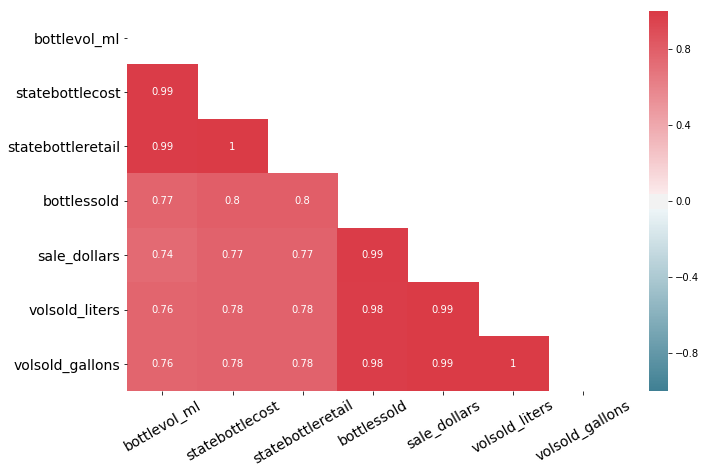

In [47]:
correlation_heat_map(stores2015)

In [68]:
##define target vector
y = stores2015[['sale_dollars']]
y.head()

,sale_dollars
storenum,
2106,146326.22
2113,9310.22
2130,111871.43
2152,7721.08
2178,24324.18


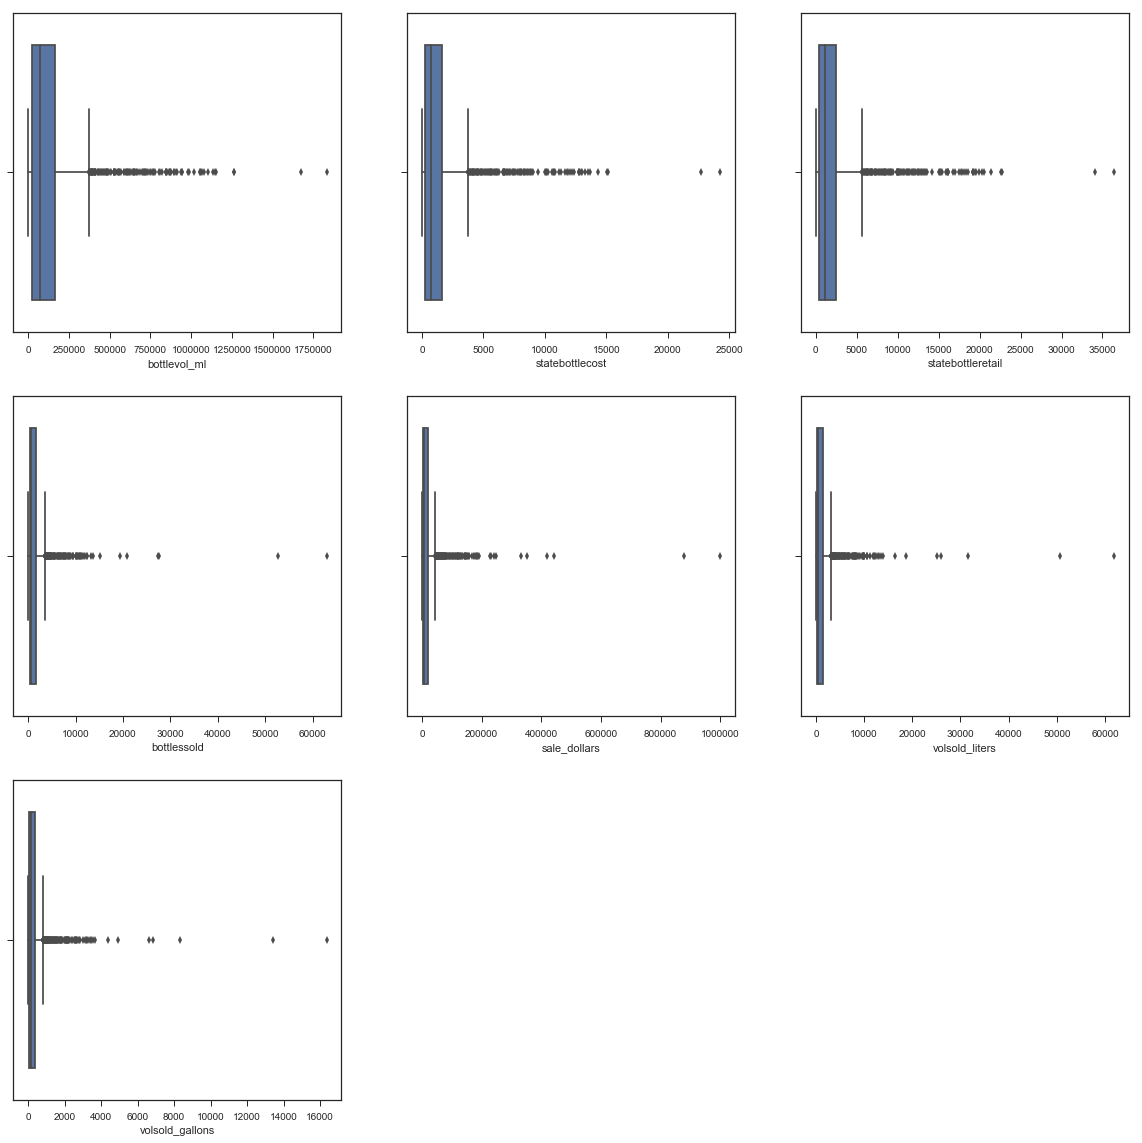

In [118]:
sns.set(style = 'ticks')

fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(331)
sns.boxplot(stores2015['bottlevol_ml'])

ax = fig.add_subplot(332)
sns.boxplot(stores2015['statebottlecost'])

ax = fig.add_subplot(333)
sns.boxplot(stores2015['statebottleretail'])

ax = fig.add_subplot(334)
sns.boxplot(stores2015['bottlessold'])

ax = fig.add_subplot(335)
sns.boxplot(stores2015['sale_dollars'])

ax = fig.add_subplot(336)
sns.boxplot(stores2015['volsold_liters'])

ax = fig.add_subplot(337)
sns.boxplot(stores2015['volsold_gallons'])


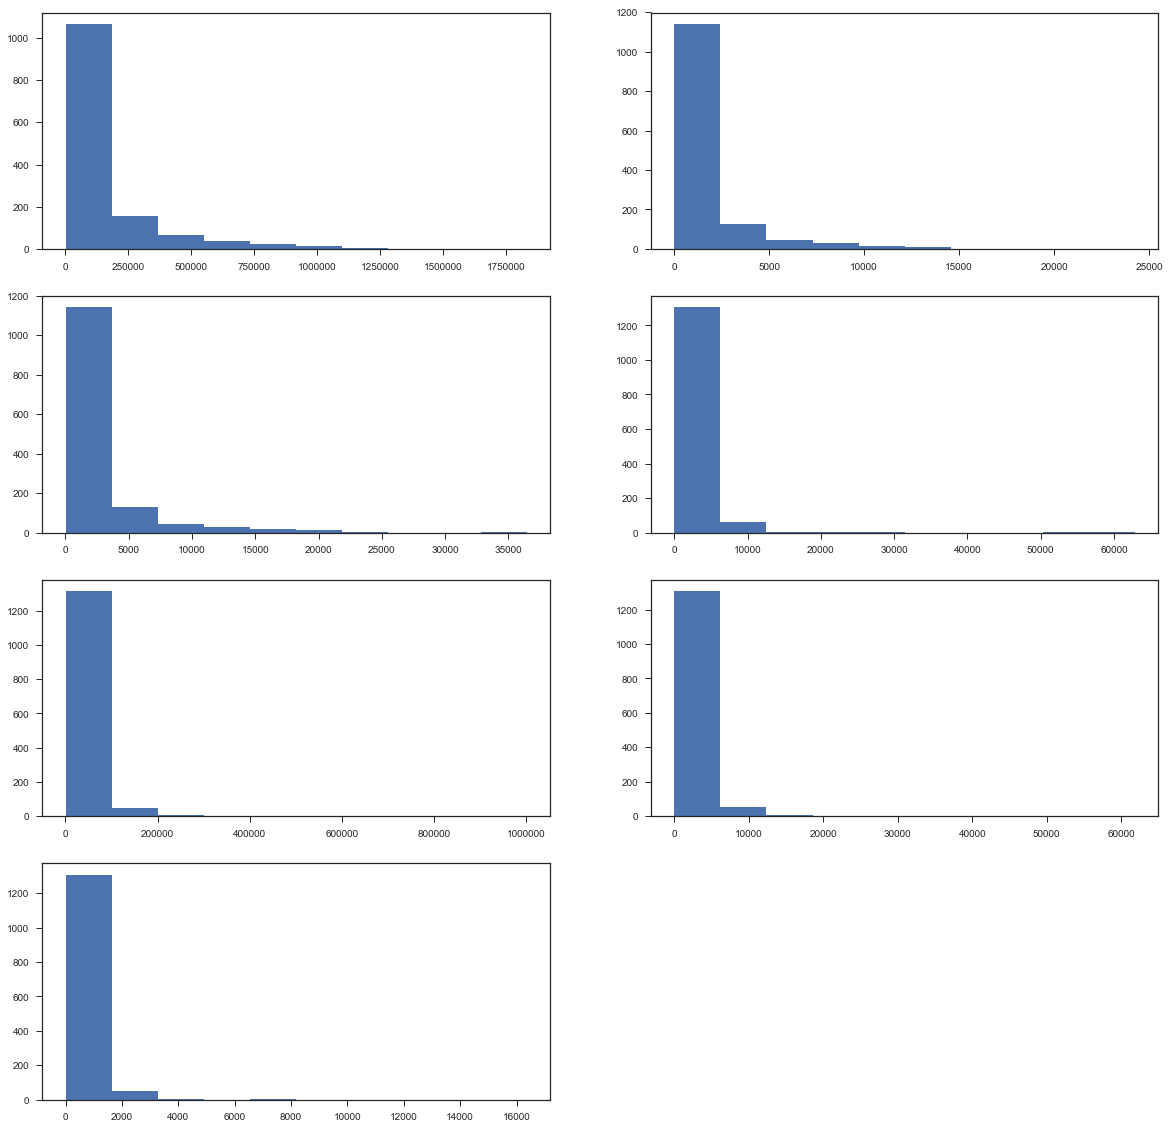

In [130]:
sns.set(style = 'ticks')

fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(421)
_ = plt.hist(x=stores2015['bottlevol_ml'])

ax = fig.add_subplot(422)
_ = plt.hist(x=stores2015['statebottlecost'])

ax = fig.add_subplot(423)
_ = plt.hist(x=stores2015['statebottleretail'])

ax = fig.add_subplot(424)
_ = plt.hist(x=stores2015['bottlessold'])

ax = fig.add_subplot(425)
_ = plt.hist(x=stores2015['sale_dollars'])

ax = fig.add_subplot(426)
_ = plt.hist(x=stores2015['volsold_liters'])

ax = fig.add_subplot(427)
_ = plt.hist(x=stores2015['volsold_gallons'])


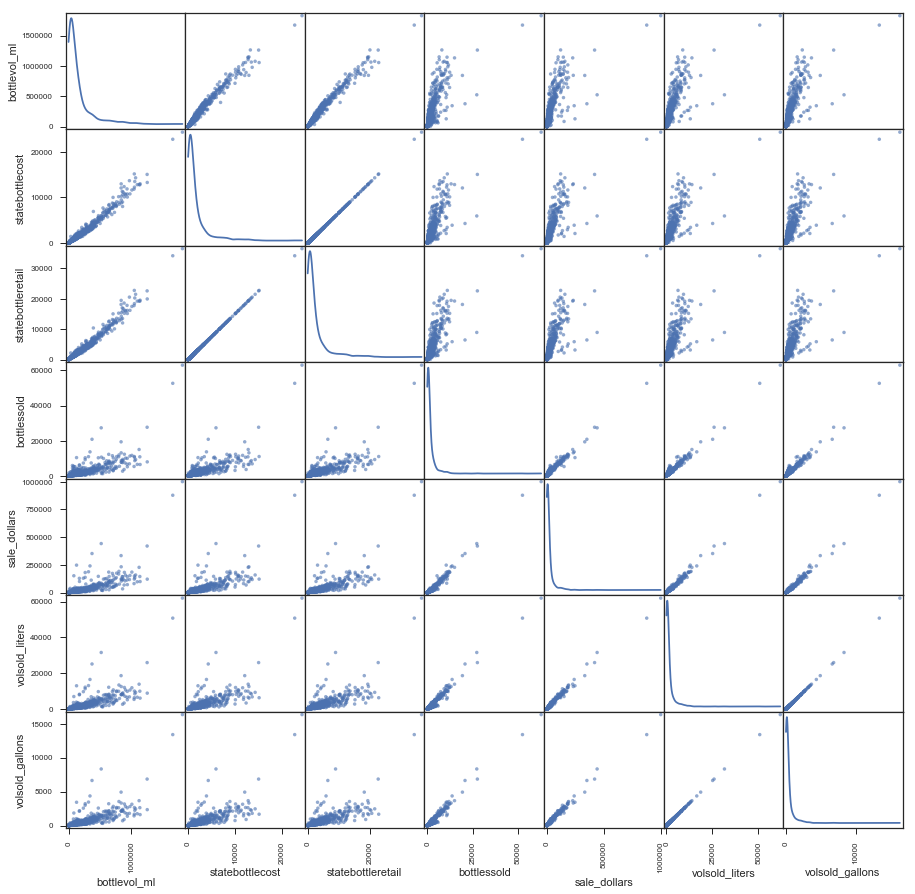

In [134]:
pd.plotting.scatter_matrix(stores2015,alpha=0.6, figsize=(15, 15), diagonal='kde');

In [53]:
county2015 = train2015.groupby('county')[['bottlevol_ml','statebottlecost',
                                          'statebottleretail','bottlessold',
                                          'sale_dollars','volsold_liters',
                                          'volsold_gallons']].sum()
county2015.head()

,bottlevol_ml,statebottlecost,statebottleretail,bottlessold,sale_dollars,volsold_liters,volsold_gallons
county,,,,,,,
Adair,476000,4276.04,6422.33,3768,43652.98,3501.22,924.73
Adams,190275,1922.16,2884.89,751,10234.88,821.16,216.68
Allamakee,867575,8182.02,12286.26,6000,79514.66,6268.00,1655.76
Appanoose,807150,7986.64,11995.16,6380,76256.05,6274.42,1657.77
Audubon,192950,1671.09,2511.16,1460,16893.29,1475.56,389.93


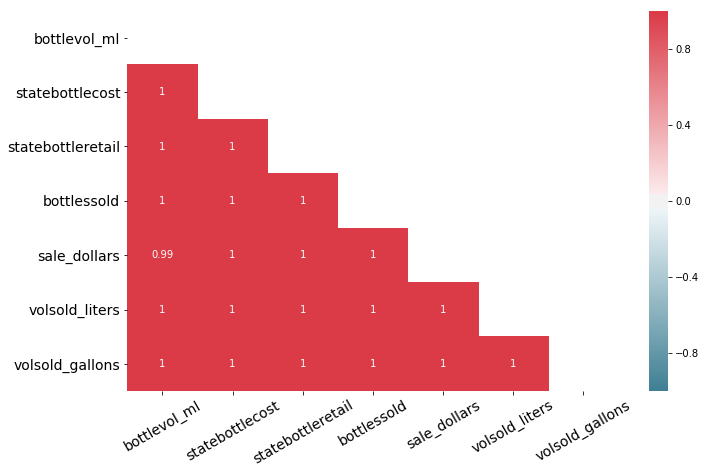

In [52]:
correlation_heat_map(county2015)

In [55]:
#https://stackoverflow.com/questions/44908383/how-can-i-group-by-month-from-a-date-field-using-python-pandas

storesmonth2015 = train2015.groupby([train2015['date'].dt.strftime('%B'),
                                     'storenum'])[['bottlevol_ml','statebottlecost',
                                                   'statebottleretail','bottlessold',
                                                   'sale_dollars','volsold_liters',
                                                   'volsold_gallons']].sum().reset_index()

,date,storenum,bottlevol_ml,statebottlecost,statebottleretail,bottlessold,sale_dollars,volsold_liters,volsold_gallons
0,April,2106,40600,403.30,605.78,1077,11957.86,1036.10,273.76
1,April,2113,4250,49.77,74.67,44,414.15,26.12,6.90
2,April,2130,38600,397.08,595.96,952,13738.75,878.90,232.22
3,April,2152,7750,48.11,72.77,19,231.52,27.75,7.33
4,April,2178,14950,120.22,181.59,84,1255.40,124.65,32.95


In [161]:
monthly = storesmonth2015.pivot(index='storenum',columns='date')

bottlevol_ml                                                        \
date            April   August December February  January     July     June   
storenum                                                                      
2106          40600.0  36500.0  41000.0  38500.0  40000.0  47750.0  42700.0   
2113           4250.0   6500.0  15750.0   7875.0  11625.0  11250.0  13750.0   
2130          38600.0  31075.0  40875.0  27450.0  22700.0  31125.0  24875.0   
2152           7750.0  15125.0  10750.0  11375.0  11625.0  19500.0   7625.0   
2178          14950.0  14950.0  26500.0  12325.0  20675.0  14200.0  33075.0   

                                       ...    volsold_gallons           \
date        March      May November    ...           December February   
storenum                               ...                               
2106      35850.0  37350.0  33750.0    ...             198.16   245.76   
2113      16375.0  10500.0  12000.0    ...              16.25    12.62   
2130      33000.0  29350.0  21375.0    ...             187.35   130.11   
2152      12000.0  15250.0  17375.0    ...              12.02    13.92   
2178      14325.0  33450.0  15500.0    ...              53.90    24.11   

                                                                             
date     January    July    June   March     May November October September  
storenum                                                                     
2106      221.07  256.17  210.17  200.58  130.95   180.72  303.14    157.43  
2113       13.62   25.62   13.21   20.56   14.99     9.09   15.91     22.55  
2130      110.96  173.58  118.90  141.26  195.97   103.13  190.81    137.12  
2152       15.23   24.07    6.10   10.93   17.88    12.56   14.40     11.71  
2178       38.33   30.73   62.72   45.84   71.96    25.49   33.68     57.98  

[5 rows x 84 columns]

In [76]:
first3 = storesmonth2015[storesmonth2015['date'].isin(['January','February','March'])]
first3 = pd.merge(first3,y.reset_index(),on='storenum')
first3.rename(columns={'sale_dollars_x':'month_sales',
                       'sale_dollars_y':'annual_sales'},inplace=True)

#first3.head()

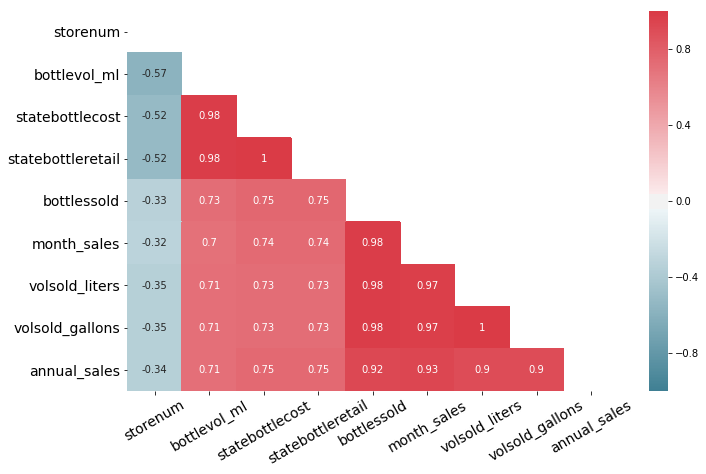

In [77]:
correlation_heat_map(first3)

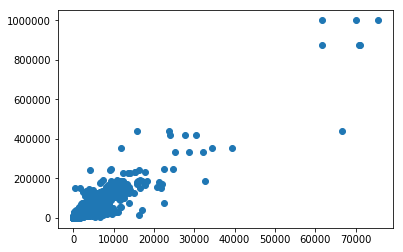

In [86]:
plt.scatter(first3['month_sales'],first3['annual_sales'])

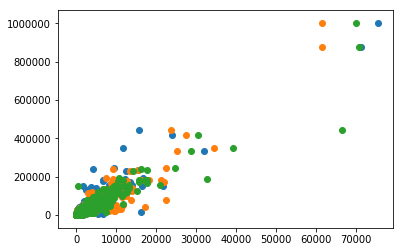

In [85]:
plt.scatter(first3[first3['date']=='January']['month_sales'],
            first3[first3['date']=='January']['annual_sales'])

plt.scatter(first3[first3['date']=='February']['month_sales'],
            first3[first3['date']=='February']['annual_sales'])

plt.scatter(first3[first3['date']=='March']['month_sales'],
            first3[first3['date']=='March']['annual_sales'])

270920

# Record your findings

Be sure to write out anything observations from your exploratory analysis.


Annual sales is tightly correlated with bottles sold, monthly sales, and volume.
Weaker, but still strong, correlation with bottle_volume, bottle cost, and retail price.

Annual sales nearly perfect correlated with every aspect of annual data.

Couple of likely outliers, probably 1 or 2 stores. Different class entirely. Investigate removing?

Distribution of sales, volume, etc.?

# Mine the data

Now you are ready to compute the variables you will use for your regression from the data. For example, you may want to compute total sales per store from Jan to March of 2015, mean price per bottle, etc. Refer to the readme for more ideas appropriate to your scenario.

Pandas is your friend for this task. Take a look at the operations here for ideas on how to make the best use of pandas and feel free to search for blog and Stack Overflow posts to help you group data by certain variables and compute sums, means, etc. You may find it useful to create a new data frame to house this summary data.
 


# Refine the data

Look for any statistical relationships, correlations, or other relevant properties of the dataset.

# Build your models

Using scikit-learn or statsmodels, build the necessary models for your scenario. Evaluate model fit.

# Plot your results

Again make sure that you record any valuable information. For example, in the tax scenario, did you find the sales from the first three months of the year to be a good predictor of the total sales for the year? Plot the predictions versus the true values and discuss the successes and limitations of your models

# Present the Results

Present your conclusions and results. If you have more than one interesting model feel free to include more than one along with a discussion. Use your work in this notebook to prepare your write-up.